In [6]:
import gc
import math
import os as os
import pickle as pkl
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import tensorflow.compat.v1 as tf
import pandas as pd

#### importing plot of usa that is made up of hundreds of grids defined as points

243


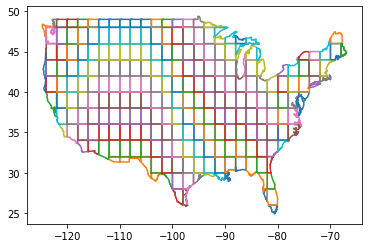

In [7]:
usaPolyGrid = pkl.load(open("util/usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(usaPolyGrid))

### Example of grid edge of USA

243


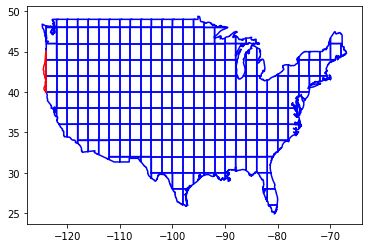

In [8]:
count = 0
for i in usaPolyGrid.values():
    if count != 0:
        plt.plot(i[:,1],i[:,0], c='blue')
    count += 1
print(len(usaPolyGrid))

poly = Polygon(np.flip(usaPolyGrid[0]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

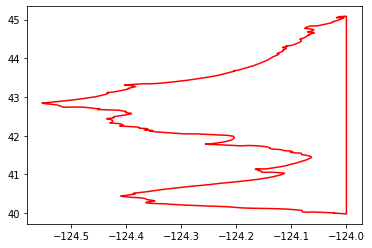

In [9]:
poly = Polygon(np.flip(usaPolyGrid[0]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

### Example of grid in middle of USA

243


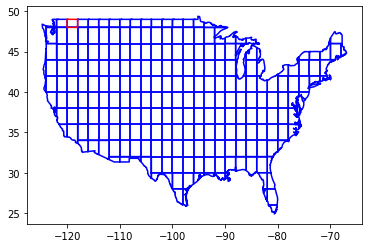

In [10]:
count = 0
for i in usaPolyGrid.values():
    if count != 23:
        plt.plot(i[:,1],i[:,0], c='blue')
    count += 1
print(len(usaPolyGrid))

poly = Polygon(np.flip(usaPolyGrid[23]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

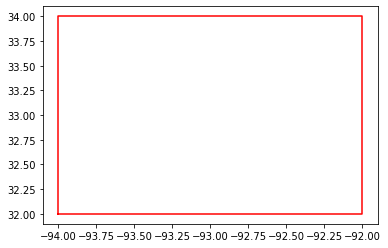

In [6]:
poly = Polygon(np.flip(usaPolyGrid[150]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

# Data scraping

In [8]:
import requests
import shutil
import pickle

def Random_Points_in_Polygon(polygon, number):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

def replace_point(points, location, polygon):
    while True:
        minx, miny, maxx, maxy = polygon.bounds
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points[points.index(location)] = pnt
            return points

def visualize_points(polygon, points):
    # Plot the polygon
    xp,yp = polygon.exterior.xy
    plt.plot(xp,yp)

    # Plot the list of points
    xs = [point.x for point in points]
    ys = [point.y for point in points]
    plt.scatter(xs, ys,color="red")
    plt.show()

key = 'Key'
url = 'https://maps.googleapis.com/maps/api/streetview?size=1000x1000&location={},{}&fov={}&heading={}&radius=10000&pitch=10&key={}'
meta_url = 'https://maps.googleapis.com/maps/api/streetview/metadata?size=1000x1000&location={},{}&fov={}&heading={}&radius=10000&pitch=10&key={}'
def save_image(image, dir, location, header):
    location_address = str(location.y) + ","+ str(location.x)
    with open(dir + "/" + str(header) + "_" + str(location_address) + ".jpg", "wb") as f:
        shutil.copyfileobj(image.raw, f)
    del image

def abort(tile_list, list_all):
    pickle.dump(list_all,open("location_progress.pkl","wb"))
    pickle.dump(tile_list, open("tile_progress.pkl", "wb"))

def get_image(location):
    check = True
    for header in [0,90,180]:
        latitude = Point(location).y
        longitude = Point(location).x
        format_url = url.format(str(latitude), str(longitude), 100, header, key)
        meta_format_url = meta_url.format(str(latitude), str(longitude), 100, header, key)
        r = requests.get(format_url, stream=True)
        meta_r = requests.get(meta_format_url, stream=True)
        meta_json = meta_r.json()
        if not r.ok or not meta_r.ok or not meta_json["status"] == 'OK':
            break
        if check:
            if meta_json["pano_id"] in all_locations :
                break
            check = False
            command = 'mkdir -p Data/' + str(tile) + "/" + str(latitude) + "," + str(longitude)
            perm_command = 'chmod -R 777 ' + 'Data/' + str(tile) + "/" + str(latitude) + "," + str(longitude)
            if not os.path.exists(command):
                p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))
                p = os.system('echo %s|sudo -S %s' % (sudoPassword, perm_command))
            all_locations.update({meta_json["pano_id"]: meta_json})

        save_image(r, 'Data/' + str(tile) + "/" + str(latitude) + "," + str(longitude), location, header)
    return check



#### Can only take 115 pictures per 1 of 243 grid of us because of Google street view api allows around 28,0000 api requests per free key.

In [12]:
sudoPassword = 'User Password'
start_tile = 0
if os.path.exists('location_progress.pkl'):
    all_locations = pkl.load(open("location_progress.pkl",'rb'))
else:
    all_locations = {}
if os.path.exists('tile_progress.pkl'):
    tile_locations = pkl.load(open("tile_progress.pkl",'rb'))
    start_tile = max(tile_locations.keys())
else:
    tile_locations = {}
for tile, points in usaPolyGrid.items():
    if tile >= start_tile:
        poly = Polygon(np.flip(points))
        gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[poly])
        rand_points = Random_Points_in_Polygon(poly, 115)
        command = 'mkdir -p Data/' + str(tile)
        if not os.path.exists('Data/' + str(tile)):
            command = 'mkdir -p Data/' + str(tile)
            perm_command = 'sudo chmod -R 777 Data/*'
            p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))
            p = os.system('echo %s|sudo -S %s' % (sudoPassword, perm_command))
        tile_pictures = []
        for location in rand_points:
            while get_image(location):
                index = rand_points.index(location)
                rand_points = replace_point(rand_points, location, poly)
                location = rand_points[index]
        tile_locations.update({tile: rand_points})

abort(tile_locations, all_locations)


NameError: name 'Random_Points_in_Polygon' is not defined

#### visualize where some pictures where taken

In [7]:
poly = Polygon(np.flip(usaPolyGrid[0]))
list = Random_Points_in_Polygon(poly, 115)
visualize_points(poly,list)
poly = Polygon(np.flip(usaPolyGrid[150]))
list = Random_Points_in_Polygon(poly, 115)
visualize_points(poly,list)

NameError: name 'Random_Points_in_Polygon' is not defined

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
import os
import collections
import random
import math

data_dir = 'Simplified_Data'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018
all_locations, TEST_EXAMPLES, TRAIN_EXAMPLES, CLASSES = [], [], [], []

for tile, points in usaPolyGrid.items():
    for x in os.listdir('Simplified_Data/' + str(tile)):
        CLASSES.append(tile)
        all_locations.append((('Simplified_Data/' + str(tile)) + '/' +  str(x), tile))
random.shuffle(all_locations)
TRAIN_EXAMPLES = all_locations[:int((len(all_locations)+1)*.80)] #Remaining 80% to training set
TEST_EXAMPLES = all_locations[int((len(all_locations)+1)*.80):] #Splits 20% data to test set
print()


KeyboardInterrupt: 

In [8]:
np.save('Training_file_names.npy' , TRAIN_EXAMPLES)
np.save('Test_file_names.npy', TEST_EXAMPLES)




In [5]:
from PIL import Image
from numpy import asarray
import gc
half = len(TEST_EXAMPLES) // 2
all_np_train = []
split_train = np.array_split(TRAIN_EXAMPLES, 10)
np_test = []
split_test = np.array_split(TEST_EXAMPLES, 3)

num = 0
for train_seg in split_train:
    for train_image, train_label in train_seg:
        img = Image.open(train_image)

        np_image = asarray(img)
        np_test.append((np_image,train_label))
    np.save('train_dataset_' + str(num) + '.npy', np_test)
    num += 1
    np_test = []
    gc.collect()



num = 0
for test_seg in split_test:
    for image, test_label in test_seg:
        img = Image.open(image)
        np_image = asarray(img)
        np_test.append((np_image,test_label))
    np.save('test_dataset_' + str(num) + '.npy', np_test)
    num += 1
    np_test = []
    gc.collect()

/home/shane/Documents/dev/Geoguessr_example/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


KeyboardInterrupt: 

In [1]:
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#
# df = pd.read_csv('train.csv')
# file_paths = df['file_name'].values
# print(file_paths)

In [14]:
# import shutil
# import random
#
# location_train = []
# list_dic_train = []
# location_test = []
# list_dic_test = []
#
# if not os.path.exists('Simplified_Data2/'):
#     os.mkdir('Simplified_Data2/')
# for tile, points in usaPolyGrid.items():
#     for x in os.listdir('Data/' + str(tile)):
#         for i in os.listdir('Data/' + str(tile) + '/' + str(x)):
#                 location_train.append(i)
#                 list_dic_train.append({'path': 'Data/' +str(tile) + '/' + str(x) +'/' + str(i), 'grid': tile})
#

In [17]:
# from collections import Counter
# counts = dict(Counter(location_train))
# duplicates = {key:value for key, value in counts.items() if value > 1}
# print(duplicates)
#

{}


In [18]:
# import csv
# header = ['path', 'grid']
# with open('locations_train.csv', 'w') as file:
#     writer = csv.DictWriter(file, fieldnames=header)
#     # Use writerows() not writerow()
#     writer.writeheader()
#     writer.writerows(list_dic_train)

In [ ]:
# header = ['degree_location', 'grid']
# with open('locations_train.csv', 'w') as file:
#     writer = csv.DictWriter(file, fieldnames=header)
#     # Use writerows() not writerow()
#     writer.writeheader()
#     writer.writerows(list_dic_test)